In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/DATA 105220014/val_df.csv'
file_path2 = '/content/drive/My Drive/DATA 105220014/train_df.csv'
file_path3 = '/content/drive/My Drive/DATA 105220014/test_df.csv'

try:
  df1 = pd.read_csv(file_path)
  df2 = pd.read_csv(file_path2)
  df3 = pd.read_csv(file_path3)
  print("File loaded successfully!")
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the path.")
except Exception as e:
  print(f"An error occurred: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File loaded successfully!


In [ ]:
!pip install langdetect

In [ ]:
!pip install datasets

In [ ]:
!pip install optuna

In [ ]:
!pip install --upgrade jax jaxlib  # Upgrade jax and jaxlib to resolve potential conflicts or bugs

In [ ]:
!pip install datasets transformers

In [ ]:
import pandas as pd
import openpyxl as bukaaja
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging
from langdetect import detect, DetectorFactory
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from datetime import datetime
from itertools import product
import ast
import optuna
from datasets import load_dataset, Dataset
import json

## Dataset
<li>df1: val_df
<li>df2: train_df
<li>df3: test_df

In [ ]:
df1.head()

,id_str,created_at,full_text,tweet_url,is_indonesian,cleaned_text,sentiment,jumlah_karakter,input_ids,attention_mask,token_type_ids,predicted_sentiment
0,1726848803976986880,Tue Nov 21 06:23:32 +0000 2023,Mengonsumsi jamu dan obat-obatan herbal yang m...,https://x.com/validnewsid/status/1726848803976...,True,mengonsumsi jamu dan obat obatan herbal yang m...,Negatif,130,"[3, 14821, 14234, 1501, 4067, 8443, 25528, 149...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Negatif
1,1305108049946800128,2024-12-15 07:23:45+00:00,"@t_secretplanet Bisa ke org dewasa kok, cuma g...",https://twitter.com/twitter/status/18681952250...,True,bisa ke org dewasa kok cuma gthu klo kbnykan b...,Netral,69,"[3, 1777, 1500, 8356, 4507, 5303, 4856, 20382,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Netral
2,1505399334770135040,Sun Mar 20 04:22:25 +0000 2022,Omar kehilangan kaki kirinya akibat penyakit d...,https://x.com/SinarOnline/status/1505399334770...,True,omar kehilangan kaki kirinya akibat penyakit d...,Netral,203,"[3, 27169, 934, 4297, 3539, 4849, 1519, 2468, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Negatif
3,1724420921346114048,Tue Nov 14 13:36:00 +0000 2023,Bisa Cegah Kanker Payudara hingga Atasi Diabet...,https://x.com/jawapos/status/1724420921346113733,True,bisa cegah kanker payudara hingga atasi diabet...,Netral,102,"[3, 1777, 8425, 6871, 6497, 2226, 1780, 1967, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Negatif
4,747796820068171776,2024-12-15 06:59:18+00:00,Kebanyakan ngulang ni video ampe diabetes \nht...,https://twitter.com/twitter/status/18681890705...,True,kebanyakan ngulang ni video ampe diabetes,Netral,41,"[3, 3908, 20628, 3724, 4031, 9203, 13365, 4, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Negatif


## Finding Best Params

In [ ]:
train_df = df2
val_df = df1
test_df = df3

In [ ]:
best_params = {'dropout': 0.1}  # Replace 0.1 with your desired default dropout value
                                # or the actual value from your optimization results

tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased", num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=3, hidden_dropout_prob=best_params["dropout"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Preprocess function
def preprocess_function(examples):
    return tokenizer(examples['cleaned_text'], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Label mapping
label_mapping = {'Positif': 0, 'Netral': 1, 'Negatif': 2}

def update_labels(example):
    example['labels'] = label_mapping[example['sentiment']]
    return example

train_dataset = train_dataset.map(update_labels)
valid_dataset = valid_dataset.map(update_labels)
test_dataset = test_dataset.map(update_labels)

# Set format for PyTorch compatibility
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
valid_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/306 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Map:   0%|          | 0/306 [00:00<?, ? examples/s]

Map:   0%|          | 0/38 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

In [ ]:
# Objective function for Bayesian Optimization
def objective(trial):
    # Hyperparameter sampling
    max_seq_length = trial.suggest_int("max_seq_length", 32, 256)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
    num_epochs = trial.suggest_int("num_epochs", 2, 10)

    # Model initialization
    model = AutoModelForSequenceClassification.from_pretrained(
        "indolem/indobertweet-base-uncased", num_labels=3, hidden_dropout_prob=dropout
    )

    # TrainingArguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        logging_dir='./logs',
        logging_steps=10,  # Log every 10 steps
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
    )

    # Train and evaluate
    trainer.train()
    eval_results = trainer.evaluate()

    # Return eval_loss for Optuna
    return eval_results["eval_loss"]

In [ ]:
# Perform Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Final training with best hyperparameters
training_args = TrainingArguments(
    output_dir="./final_results",
    evaluation_strategy="epoch",
    logging_dir='./final_logs',
    logging_steps=10,
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_epochs"],
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

trainer.train()

# Evaluate final model on test set
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test set results:", test_results)

# Save results
with open("hyperparameter_results.txt", "w") as f:
    f.write(f"Best hyperparameters: {study.best_params}\n")
    f.write(f"Test set results: {test_results}\n")

[I 2025-02-04 14:37:16,536] A new study created in memory with name: no-name-cf8c7c85-f8f0-4abb-8e05-57790b9793ff
<ipython-input-12-12a0e120376b>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-12-12a0e120376b>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

Epoch,Training Loss,Validation Loss
1,0.660500,0.685159
2,0.565800,0.670063
3,0.347500,0.597238
4,0.312500,0.686121
5,0.246900,0.654753
6,0.348900,0.670619


[I 2025-02-04 16:22:51,401] Trial 0 finished with value: 0.5972378849983215 and parameters: {'max_seq_length': 175, 'batch_size': 16, 'dropout': 0.24322255778877744, 'learning_rate': 7.928920088689245e-05, 'num_epochs': 6}. Best is trial 0 with value: 0.5972378849983215.
<ipython-input-12-12a0e120376b>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
<ipython-input-12-12a0e120376b>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are n

In [ ]:
# 7. TrainingArguments
training_args = TrainingArguments(
    output_dir="./final_results",
    evaluation_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_epochs"],
    weight_decay=0.01,
    logging_dir='./final_logs',
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="epoch",
    report_to="none",
    load_best_model_at_end=True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import Trainer, EarlyStoppingCallback

# Hyperparameter terbaik
best_params = {
    'max_seq_length': 53,
    'batch_size': 16,
    'dropout': 0.24231129174718147,
    'learning_rate': 1.22e-5,
    'num_epochs': 10
}

def evaluate_model(trainer, eval_dataset, label_mapping=None):
    predictions, labels, _ = trainer.predict(eval_dataset)
    preds = np.argmax(predictions, axis=1)

    overall_scores = {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1_score": f1_score(labels, preds, average="weighted")
    }

    class_report = classification_report(
        labels, preds,
        target_names=label_mapping.values() if label_mapping else None,
        output_dict=True
    )

    eval_scores = {
        "positive": class_report.get("positive", {}),
        "negative": class_report.get("negative", {}),
        "neutral": class_report.get("neutral", {})
    }

    return {
        "overall_scores": overall_scores,
        "evaluation_scores": eval_scores,
        "classification_report": class_report
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

try:
    trainer.train()
except Exception as e:
    print(f"Error during training: {e}")

# Evaluasi tetap dijalankan meskipun training error
try:
    results = {"IndoBERTweet": evaluate_model(trainer, test_dataset)}
    print("Evaluation Results:", results)
except Exception as e:
    print(f"Error during evaluation: {e}")


Epoch,Training Loss,Validation Loss
1,0.000000,1.479009
2,0.000000,1.634625
3,0.000800,1.784667


Evaluation Results: {'IndoBERTweet': {'overall_scores': {'accuracy': 0.8974358974358975, 'precision': 0.8992314874667817, 'recall': 0.8974358974358975, 'f1_score': 0.8977069442185722}, 'evaluation_scores': {'positive': {}, 'negative': {}, 'neutral': {}}, 'classification_report': {'0': {'precision': 0.8823529411764706, 'recall': 0.9375, 'f1-score': 0.9090909090909091, 'support': 16.0}, '1': {'precision': 0.9523809523809523, 'recall': 0.9090909090909091, 'f1-score': 0.9302325581395349, 'support': 22.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, 'accuracy': 0.8974358974358975, 'macro avg': {'precision': 0.6115779645191409, 'recall': 0.6155303030303031, 'f1-score': 0.6131078224101479, 'support': 39.0}, 'weighted avg': {'precision': 0.8992314874667817, 'recall': 0.8974358974358975, 'f1-score': 0.8977069442185722, 'support': 39.0}}}}


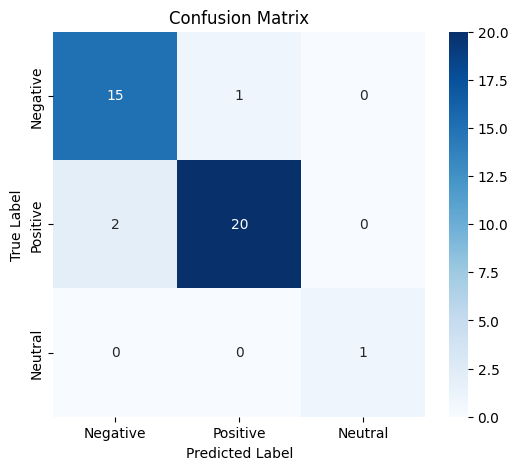

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data evaluasi model
labels_true = [0] * 16 + [1] * 22 + [2] * 1  # Sesuai dengan "support"
labels_pred = [0] * 15 + [1] * 1 + [1] * 20 + [0] * 2 + [2] * 1  # Prediksi berdasarkan precision/recall

# Buat confusion matrix
cm = confusion_matrix(labels_true, labels_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Data hasil evaluasi IndoBERTweet
y_true = np.array(labels_true)
y_pred = np.array(labels_pred)

# Buat classification report
report = classification_report(y_true, y_pred, target_names=["Negative", "Positive", "Neutral"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Tampilkan tabel
print(df_report)


              precision    recall  f1-score    support
Negative       0.882353  0.937500  0.909091  16.000000
Positive       0.952381  0.909091  0.930233  22.000000
Neutral        1.000000  1.000000  1.000000   1.000000
accuracy       0.923077  0.923077  0.923077   0.923077
macro avg      0.944911  0.948864  0.946441  39.000000
weighted avg   0.924873  0.923077  0.923348  39.000000
